In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import torch
from torch import nn
from tqdm.notebook import tqdm
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

current_dir = Path.cwd()
import sys
import gc

sys.path.append(str(current_dir.parent))
from utils import get_competition_data_path, submit
%matplotlib inline

In [2]:
path_dict = get_competition_data_path("m5-forecasting-accuracy")
competition_path = path_dict.get("competition_path")
train_path = path_dict.get("train_path")
submission_path = path_dict.get("sample_submission_path")
calendar_path = competition_path / "calendar.csv"
sell_prices_path = competition_path / "sell_prices.csv"

In [3]:
plt.rcParams["figure.figsize"] = 14, 6
sns.set()

## Objectives
The objective of the M5 forecasting competition is to advance the theory and practice of forecasting by identifying the method(s) that provide the most accurate point forecasts for each of the 42,840 time series of the competition. I addition, to elicit information to estimate the uncertainty distribution of the realized values of these series as precisely as possible. 
To that end, the participants of M5 are asked to provide 28 days ahead point forecasts (PFs) for all the series of the competition, as well as the corresponding median and 50%, 67%, 95%, and 99% prediction intervals (PIs).
The M5 differs from the previous four ones in five important ways, some of them suggested by the discussants of the M4  competition, as follows:
- First, it uses grouped unit sales data, starting at the product-store level and being aggregated to that of product departments, product categories, stores, and three geographical areas: the States of California (CA), Texas (TX), and Wisconsin (WI).
- Second, besides the time series data, it includes explanatory variables such as sell prices, promotions, days of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter) that typically affect unit sales and could improve forecasting accuracy.
- Third, in addition to point forecasts, it assesses the distribution of uncertainty, as the participants are asked to provide information on nine indicative quantiles.
- Fourth, instead of having a single competition to estimate both the point forecasts and the uncertainty distribution, there will be two parallel tracks using the same dataset, the first requiring 28 days ahead point forecasts and the second 28 days ahead probabilistic forecasts for the median and four prediction intervals (50%, 67%, 95%, and 99%).
- Fifth, for the first time it focuses on series that display intermittency, i.e., sporadic demand including zeros.

## Datasets info
The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI)

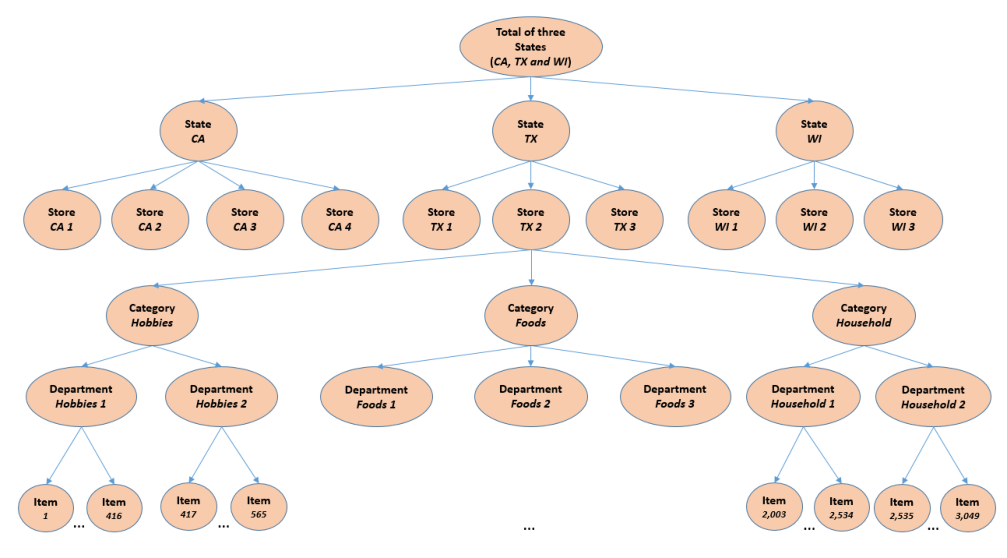

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sns.set()
plt.rcParams["figure.figsize"] = 20, 10

img = mpimg.imread("../data/m5-forecasting-accuracy/m5-forecasting-hierarchical.png")
imgplot = plt.imshow(img)
plt.grid(False)
plt.axis("off")
plt.show()

Remove outlier days: Xmas

In [5]:
plt.rcParams["figure.figsize"] = 14, 6

Model choice
- I decide to turn the time series problem into a supervised learning problem
- Reasons:
    - There's no existing package (that I know of) for time series analysis and forecast capable of dealing of this much amount of time series (statsmodels can only fit one series at a time)
    - It's more straight forward to incorporate external features 
    - Random Forests and LightGBM are powerful algorithm that do really well in many types of problem, including time series forecast

- Initial Model:
    - Existing Features
    - Random Forest
    - 28 days at once
- Enhance 1:
    - Existing
    - Random Forest
    - Day by day
    - 7 day by 7 day
    - Average
- Enhance 2:
    - Existing + New Features
    - Random Forest
    - 28, 7, 1 
    - Average
- Enhance 3
    - Existing + New Features
    - LightGBM
    - 28, 7, 1 
    - Average
    
- Note: Find a way to check learning curve and train vs val score
- Split the data into 3
    - train
    - val
    - test

## Initial Model

#### Get existing features

Turn calendar into features, i.e. turn any categorical features

In [6]:
calendar = pd.read_csv(calendar_path)

In [7]:
encoder = OrdinalEncoder(dtype='int')

# Convert event to number
all_event_names = np.append(calendar['event_name_1'].dropna().unique(), calendar['event_name_2'].dropna().unique()).reshape(-1, 1)
all_event_types = np.append(calendar['event_type_1'].dropna().unique(), calendar['event_type_2'].dropna().unique()).reshape(-1, 1)

name_codes = encoder.fit_transform(all_event_names) 
name_codes_dict = dict(zip(all_event_names.flatten().tolist(), name_codes.flatten().tolist()))

type_codes = encoder.fit_transform(all_event_types) 
type_codes_dict = dict(zip(all_event_types.flatten().tolist(), type_codes.flatten().tolist()))

event_name_1 = calendar['event_name_1'].map(name_codes_dict).fillna(-1).astype('int')
event_name_2 = calendar['event_name_2'].map(name_codes_dict).fillna(-1).astype('int')

event_type_1 = calendar['event_type_1'].map(type_codes_dict).fillna(-1).astype('int')
event_type_2 = calendar['event_type_2'].map(type_codes_dict).fillna(-1).astype('int')

# Change d to number
d = calendar['d'].str.split('_', expand=True)[1].tolist()

# Get quarter
quarter = pd.to_datetime(calendar['date']).dt.quarter


calendar = calendar.assign(d=d, quarter=quarter, event_name_1=event_name_1, event_type_1=event_type_1, event_name_2=event_name_2, event_type_2=event_type_2)
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter
0,2011-01-29,11101,Saturday,1,1,2011,1,-1,-1,-1,-1,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,2,-1,-1,-1,-1,0,0,0,1
2,2011-01-31,11101,Monday,3,1,2011,3,-1,-1,-1,-1,0,0,0,1
3,2011-02-01,11101,Tuesday,4,2,2011,4,-1,-1,-1,-1,1,1,0,1
4,2011-02-02,11101,Wednesday,5,2,2011,5,-1,-1,-1,-1,1,0,1,1


Sales:
- Changes days of sales to number
- Turn to long format

In [20]:
sales = pd.read_csv(train_path)
sample_submission = pd.read_csv(submission_path)

outliers = ['d_331', 'd_697', 'd_1062', 'd_1427', 'd_1792']
sales = sales.loc[:, ~sales.columns.isin(outliers)]
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [21]:
sales_cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [22]:
subset = 800

In [23]:
# Turn d into number
d = sales.columns[6:].to_series().str.split('_', expand=True)[1].tolist()
sales.columns = sales.columns[:6].tolist() + d

# Keep only necessary columns
sales = sales.drop(columns=['id'])

# Use a subset of d 
if subset:
    d = d[-subset:]
sales = sales.reindex(columns=sales_cat_features + d)

In [24]:
# Encode cat features to number
item_id = encoder.fit_transform(sales[['item_id']]).astype(int)
dept_id = encoder.fit_transform(sales[['dept_id']]).astype(int)
cat_id = encoder.fit_transform(sales[['cat_id']]).astype(int)
store_id = encoder.fit_transform(sales[['store_id']]).astype(int)
state_id = encoder.fit_transform(sales[['state_id']]).astype(int)

# Get item dict to map back later
item_id_dict = dict(zip(sales['item_id'], item_id.flatten()))
dept_id_dict = dict(zip(sales['dept_id'], dept_id.flatten()))
cat_id_dict = dict(zip(sales['cat_id'], cat_id.flatten()))
store_id_dict = dict(zip(sales['store_id'], store_id.flatten()))

In [25]:
# Assign number values
sales = sales.assign(item_id=item_id, dept_id=dept_id, cat_id=cat_id, store_id=store_id, state_id=state_id)

# To long format
sales = sales.melt(id_vars=sales_cat_features, var_name='d', value_name='sale')

sales.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sale
0,1437,3,1,0,0,1112,0
1,1438,3,1,0,0,1112,0
2,1439,3,1,0,0,1112,0
3,1440,3,1,0,0,1112,3
4,1441,3,1,0,0,1112,1


In [26]:
gc.collect()

5609

Attach days to price and convert categorical columns to number

In [18]:
sell_prices = pd.read_csv(sell_prices_path)
sell_prices = sell_prices.assign(item_id=sell_prices['item_id'].map(item_id_dict), store_id=sell_prices['store_id'].map(store_id_dict))
sell_prices = sell_prices.merge(calendar[['wm_yr_wk', 'd']], how='left').drop(columns='wm_yr_wk')
sell_prices.head()

,store_id,item_id,sell_price,d
0,0,1437,9.58,897
1,0,1437,9.58,898
2,0,1437,9.58,899
3,0,1437,9.58,900
4,0,1437,9.58,901


Attach calendar and prices to sales

In [27]:
sales = sales.merge(sell_prices, on=['d', 'item_id', 'store_id'], how='inner')

In [30]:
sales = sales.merge(calendar, on='d')

In [31]:
del calendar, sell_prices
gc.collect()

2416

In [32]:
sales

,item_id,dept_id,cat_id,store_id,state_id,d,sale,sell_price,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter
0,1437,3,1,0,0,1112,0,8.26,2014-02-13,11402,...,2,2014,-1,-1,-1,-1,0,1,0,1
1,1438,3,1,0,0,1112,0,3.97,2014-02-13,11402,...,2,2014,-1,-1,-1,-1,0,1,0,1
2,1439,3,1,0,0,1112,0,2.97,2014-02-13,11402,...,2,2014,-1,-1,-1,-1,0,1,0,1
3,1440,3,1,0,0,1112,3,4.64,2014-02-13,11402,...,2,2014,-1,-1,-1,-1,0,1,0,1
4,1441,3,1,0,0,1112,1,3.08,2014-02-13,11402,...,2,2014,-1,-1,-1,-1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23636708,1432,2,0,9,2,1913,1,2.98,2016-04-24,11613,...,4,2016,-1,-1,-1,-1,0,0,0,2
23636709,1433,2,0,9,2,1913,0,2.48,2016-04-24,11613,...,4,2016,-1,-1,-1,-1,0,0,0,2
23636710,1434,2,0,9,2,1913,0,3.98,2016-04-24,11613,...,4,2016,-1,-1,-1,-1,0,0,0,2
23636711,1435,2,0,9,2,1913,3,1.28,2016-04-24,11613,...,4,2016,-1,-1,-1,-1,0,0,0,2


KeyboardInterrupt: 

In [33]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23636713 entries, 0 to 23636712
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       int32  
 1   dept_id       int32  
 2   cat_id        int32  
 3   store_id      int32  
 4   state_id      int32  
 5   d             object 
 6   sale          int64  
 7   sell_price    float64
 8   date          object 
 9   wm_yr_wk      int64  
 10  weekday       object 
 11  wday          int64  
 12  month         int64  
 13  year          int64  
 14  event_name_1  int32  
 15  event_type_1  int32  
 16  event_name_2  int32  
 17  event_type_2  int32  
 18  snap_CA       int64  
 19  snap_TX       int64  
 20  snap_WI       int64  
 21  quarter       int64  
dtypes: float64(1), int32(9), int64(9), object(3)
memory usage: 3.3+ GB


In [ ]:
sales.to_csv('sales.csv', index=False)